In [1]:
# Step0 Setup
from pathlib import Path
import sys
import json
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.base import clone
from scipy.stats import t
import joblib

# --- SciPy-Kompatibilität: binom_test wurde ab SciPy >= 1.11 entfernt ---
# Erlaubt weiterhin den Aufruf binom_test([b, c]) in Step5 (McNemar via Binomialtest)
try:
    from scipy.stats import binom_test  # SciPy <= 1.10
except Exception:
    from scipy.stats import binomtest as _binomtest  # SciPy >= 1.11 (z.B. 1.16.0)
    def binom_test(x, p=0.5, alternative="two-sided"):
        import numpy as _np
        # erwartet wie im Notebook [b, c] = discordante Paare
        if isinstance(x, (list, tuple, _np.ndarray)) and len(x) == 2:
            b, c = int(x[0]), int(x[1])
            k = min(b, c)
            n = b + c
            return _binomtest(k, n, p=p, alternative=alternative).pvalue
        raise TypeError("binom_test shim erwartet eine 2-längige Sequenz [b, c].")

warnings.filterwarnings("ignore")

# --- Logging ---
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s | %(message)s")
logger = logging.getLogger(__name__)

# --- Artefakt-Pfade einrichten ---
def find_project_root(start: Path) -> Path:
    start = start.resolve()
    chain = [start, *start.parents]
    # 1) Bevorzugt: exakte Daten-Datei vorhanden (verhindert notebooks\artifacts-Falle)
    for p in chain:
        if (p / "artifacts" / "data" / "features_monthly.parquet").exists():
            return p
    # 2) Falls nur das artifacts/data-Verzeichnis existiert
    for p in chain:
        if (p / "artifacts" / "data").exists():
            return p
    # 3) Klassische Marker (falls du config/src als Root-Kriterium nutzt)
    for p in chain:
        if (p / "config").exists() and (p / "src").exists():
            return p
    raise AssertionError("Project root not found – expected 'artifacts/data' or 'config'+'src' somewhere above.")

ROOT = find_project_root(Path.cwd())
ARTIFACTS = ROOT / "artifacts"
DATA_DIR = ARTIFACTS / "data"
CONF_DIR = ARTIFACTS / "config"
FORECASTS_DIR = ARTIFACTS / "forecasts"
METRICS_DIR = ARTIFACTS / "metrics"
REPORTS_DIR = ARTIFACTS / "reports"
MODELS_DIR = ARTIFACTS / "models"  # für Step8

for p in [DATA_DIR, CONF_DIR, FORECASTS_DIR, METRICS_DIR, REPORTS_DIR, MODELS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

logger.info(f"ROOT={ROOT} | DATA_DIR={DATA_DIR}")


INFO | ROOT=C:\Users\gamer\Desktop\AktienPrognose | DATA_DIR=C:\Users\gamer\Desktop\AktienPrognose\artifacts\data


In [2]:
# Step1 Daten/Featuresets
# Load preprocessed monthly features and target (DatetimeIndex)

df = pd.read_parquet(DATA_DIR / "features_monthly.parquet")
df = df.sort_index()  # ensure chronological order

# Define feature sets
tech_cols = ["Return_Lag1", "3M_SMA_Return", "12M_SMA_Return", "3M_Momentum", "Volatility_6M"]
macro_cols = ["FedFunds_Delta_bps", "Inflation_YoY_pct",
              "UnemploymentRate", "VIX", "EPU_US", "FSI", "Gold_USD_oz", "WTI_Spot", "USD_per_EUR"]

X_tech = df[tech_cols].copy()
X_macro = df[macro_cols].copy()
X_integrated = df[tech_cols + macro_cols].copy()
y = df["y_direction_next"].astype(int)


In [3]:
# Step2 TSCV-Splitter
# Expanding window TimeSeriesSplit (gap=1 to enforce embargo)

tscv = TimeSeriesSplit(n_splits=5, test_size=12, gap=1)
logger.info(f"TimeSeriesSplit: {tscv}")


INFO | TimeSeriesSplit: TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=12)


In [4]:
# Step3 Grid-Search + OOF-Kalibrierung + Threshold-Findung
param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 2, 3],
    "max_features": ["sqrt", "log2"]
}

best_models = {}
calibrators = {}
thresholds = {}

for fs_name, X in [("TECH", X_tech), ("MACRO", X_macro), ("INTEGRATED", X_integrated)]:
    logger.info(f"Grid search for feature set: {fs_name}")
    base_clf = RandomForestClassifier(class_weight="balanced_subsample", random_state=42)
    grid = GridSearchCV(base_clf, param_grid, scoring="f1", cv=tscv, n_jobs=-1)
    grid.fit(X, y)
    best = grid.best_estimator_
    best_models[fs_name] = best

    # Out-of-Fold predictions for calibration
    oof_proba = np.zeros(len(y))
    for train_idx, test_idx in tscv.split(X):
        m = clone(best)
        m.fit(X.iloc[train_idx], y.iloc[train_idx])
        oof_proba[test_idx] = m.predict_proba(X.iloc[test_idx])[:, 1]

    # Platt scaling (Logistic Regression):contentReference[oaicite:3]{index=3}
    lr = LogisticRegression(solver="lbfgs")
    lr.fit(oof_proba.reshape(-1, 1), y)
    calibrators[fs_name] = lr

    # Find threshold maximizing F1 on OOF calibrated probabilities
    prob_cal = lr.predict_proba(oof_proba.reshape(-1,1))[:,1]
    best_thr, best_f1 = 0.0, 0.0
    for thr in np.linspace(0, 1, 101):
        y_pred_thr = (prob_cal >= thr).astype(int)
        f1 = f1_score(y, y_pred_thr, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    thresholds[fs_name] = best_thr
    logger.info(f"{fs_name} best params: {grid.best_params_}, best OOF F1: {best_f1:.3f}, threshold: {best_thr:.2f}")

logger.info(f"Thresholds: {thresholds}")


INFO | Grid search for feature set: TECH
INFO | TECH best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 500}, best OOF F1: 0.801, threshold: 0.00
INFO | Grid search for feature set: MACRO
INFO | MACRO best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}, best OOF F1: 0.801, threshold: 0.00
INFO | Grid search for feature set: INTEGRATED
INFO | INTEGRATED best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 300}, best OOF F1: 0.801, threshold: 0.00
INFO | Thresholds: {'TECH': np.float64(0.0), 'MACRO': np.float64(0.0), 'INTEGRATED': np.float64(0.0)}


In [5]:
# Step4 Walk-Forward-Test
walkforecasts = {}
logit_forecasts = {}

for fs_name, X in [("TECH", X_tech), ("MACRO", X_macro), ("INTEGRATED", X_integrated)]:
    best = best_models[fs_name]
    lr = calibrators[fs_name]
    thr = thresholds[fs_name]

    all_idx, all_y, all_proba, all_pred, all_ret = [], [], [], [], []

    # Perform expanding-origin evaluation
    for train_idx, test_idx in tscv.split(X):
        m = clone(best)
        m.fit(X.iloc[train_idx], y.iloc[train_idx])
        proba = m.predict_proba(X.iloc[test_idx])[:, 1]
        proba_cal = lr.predict_proba(proba.reshape(-1,1))[:, 1]
        preds = (proba_cal >= thr).astype(int)

        all_idx.extend(X.index[test_idx])
        all_y.extend(y.iloc[test_idx])
        all_proba.extend(proba_cal)
        all_pred.extend(preds)
        all_ret.extend(df["y_return_next_pct"].iloc[test_idx])  # actual return for the months

    df_fore = pd.DataFrame({
        "y_true": all_y,
        "y_pred": all_pred,
        "proba": all_proba,
        "y_ret": all_ret
    }, index=all_idx).sort_index()

    walkforecasts[fs_name] = df_fore

    # Logistic baseline via same expanding procedure
    logit = LogisticRegression(class_weight="balanced", solver="lbfgs", max_iter=1000)
    l_idx, l_y, l_pred = [], [], []
    for train_idx, test_idx in tscv.split(X):
        logit.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds_log = logit.predict(X.iloc[test_idx])
        l_idx.extend(X.index[test_idx])
        l_y.extend(y.iloc[test_idx])
        l_pred.extend(preds_log)
    df_logit = pd.DataFrame({"y_true": l_y, "y_pred": l_pred}, index=l_idx).sort_index()
    logit_forecasts[fs_name] = df_logit


In [7]:
# Step5 Metriken/Signifikanz/JSON
# Classification metrics and persistence
for fs_name, df_fore in walkforecasts.items():
    y_true = df_fore["y_true"]
    y_pred = df_fore["y_pred"]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    metrics = {"Accuracy": float(acc), "F1": float(f1)}

    # Save metrics JSON
    out_path = METRICS_DIR / f"rf_clf_{fs_name}.json"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(json.dumps(metrics, indent=2))
    logger.info(f"Metrics for {fs_name}: {metrics}")

# Significance tests
def _dm_test(loss_a, loss_b):
    """Return (stat, p) for Diebold–Mariano on 0/1-loss; robust if var=0 or n<2."""
    d = np.asarray(loss_a, dtype=float) - np.asarray(loss_b, dtype=float)
    n = d.size
    if n < 2:
        return 0.0, 1.0
    var = d.var(ddof=1)
    if var == 0 or not np.isfinite(var):
        return 0.0, 1.0
    stat = d.mean() / np.sqrt(var / n)
    p = 2 * (1 - t.cdf(abs(stat), df=n - 1))
    return float(stat), float(p)

for fs_name in ["TECH", "MACRO", "INTEGRATED"]:
    df_rf = walkforecasts[fs_name]
    df_log = logit_forecasts[fs_name].loc[df_rf.index]  # align indices

    y_t = df_rf["y_true"]
    rf_pred = df_rf["y_pred"]
    log_pred = df_log["y_pred"]

    # Always-up baseline (predict 1)
    au_pred = pd.Series(1, index=y_t.index)

    # 0/1-loss
    e_rf  = (y_t != rf_pred).astype(int)
    e_au  = (y_t != au_pred).astype(int)
    e_log = (y_t != log_pred).astype(int)

    # Diebold–Mariano
    dm_stat1, p_val1 = _dm_test(e_rf.values, e_au.values)
    dm_stat2, p_val2 = _dm_test(e_rf.values, e_log.values)

    # McNemar vs Always-Up (discordant pairs only)
    b = int(((y_t == 1) & (rf_pred == 0)).sum())  # baseline correct, RF wrong
    c = int(((y_t == 0) & (rf_pred == 0)).sum())  # RF correct, baseline wrong
    n = b + c
    if n == 0:
        p_mcnemar = 1.0
        logger.info(f"McNemar ({fs_name}): keine discordanten Paare (b+c=0) → p=1.0 (Test übersprungen)")
    else:
        # nutzt den Step0-Compat-Shim für SciPy >= 1.11
        p_mcnemar = binom_test([b, c])

    logger.info(
        f"Significance ({fs_name}): "
        f"DM(RF vs AU) stat={dm_stat1:.3f}, p={p_val1:.3f}; "
        f"DM(RF vs Logit) stat={dm_stat2:.3f}, p={p_val2:.3f}; "
        f"McNemar_vs_AU p={p_mcnemar:.3f}"
    )


INFO | Metrics for TECH: {'Accuracy': 0.6333333333333333, 'F1': 0.7755102040816326}
INFO | Metrics for MACRO: {'Accuracy': 0.6333333333333333, 'F1': 0.7755102040816326}
INFO | Metrics for INTEGRATED: {'Accuracy': 0.6333333333333333, 'F1': 0.7755102040816326}
INFO | McNemar (TECH): keine discordanten Paare (b+c=0) → p=1.0 (Test übersprungen)
INFO | Significance (TECH): DM(RF vs AU) stat=0.000, p=1.000; DM(RF vs Logit) stat=-1.154, p=0.253; McNemar_vs_AU p=1.000
INFO | McNemar (MACRO): keine discordanten Paare (b+c=0) → p=1.0 (Test übersprungen)
INFO | Significance (MACRO): DM(RF vs AU) stat=0.000, p=1.000; DM(RF vs Logit) stat=-2.076, p=0.042; McNemar_vs_AU p=1.000
INFO | McNemar (INTEGRATED): keine discordanten Paare (b+c=0) → p=1.0 (Test übersprungen)
INFO | Significance (INTEGRATED): DM(RF vs AU) stat=0.000, p=1.000; DM(RF vs Logit) stat=-1.382, p=0.172; McNemar_vs_AU p=1.000


In [8]:
# Step6 Explainability
importances_csv_dir = ARTIFACTS / "importances"
importances_csv_dir.mkdir(parents=True, exist_ok=True)

for fs_name, X in [("TECH", X_tech), ("MACRO", X_macro), ("INTEGRATED", X_integrated)]:
    model = clone(best_models[fs_name])
    # Retrain on last fold's training data
    train_idx, test_idx = list(tscv.split(X))[-1]
    model.fit(X.iloc[train_idx], y.iloc[train_idx])

    # Permutation importance (based on log loss)
    res = permutation_importance(
        model, X.iloc[train_idx], y.iloc[train_idx],
        scoring="neg_log_loss", n_repeats=10, random_state=42
    )
    imp_mean = res.importances_mean
    imp_df = pd.Series(imp_mean, index=X.columns).sort_values(ascending=False)
    top20 = imp_df.head(20)
    top20.to_csv(importances_csv_dir / f"{fs_name}perm_importances_top20.csv")
    logger.info(f"Top20 permutation importances for {fs_name} saved")

    # Gini (MDI) importances
    logger.info(f"Gini importances {fs_name}: {list(model.feature_importances_)}")
for fs_name, df_fore in walkforecasts.items():
    y_true = df_fore["y_true"]
    y_pred = df_fore["y_pred"]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    metrics = {"Accuracy": float(acc), "F1": float(f1)}

    # Save metrics JSON
    out_path = METRICS_DIR / f"rf_clf_{fs_name}.json"
    out_path.parent.mkdir(parents=True, exist_ok=True)
    out_path.write_text(json.dumps(metrics, indent=2))
    logger.info(f"Metrics for {fs_name}: {metrics}")


INFO | Top20 permutation importances for TECH saved
INFO | Gini importances TECH: [np.float64(0.18793363463705637), np.float64(0.176132780631613), np.float64(0.24088971883429), np.float64(0.17110650153208126), np.float64(0.22393736436495948)]
INFO | Top20 permutation importances for MACRO saved
INFO | Gini importances MACRO: [np.float64(0.08253627300400444), np.float64(0.11764775268879343), np.float64(0.07627634637573728), np.float64(0.12467007013826462), np.float64(0.1321223638827071), np.float64(0.1160470645552967), np.float64(0.1208602569084256), np.float64(0.10956430119495861), np.float64(0.12027557125181225)]
INFO | Top20 permutation importances for INTEGRATED saved
INFO | Gini importances INTEGRATED: [np.float64(0.0718885680486342), np.float64(0.06590310276178088), np.float64(0.09581502680666469), np.float64(0.05878079804390178), np.float64(0.07663251810484267), np.float64(0.05729000413049571), np.float64(0.0827701602246074), np.float64(0.05102701100091536), np.float64(0.07142661

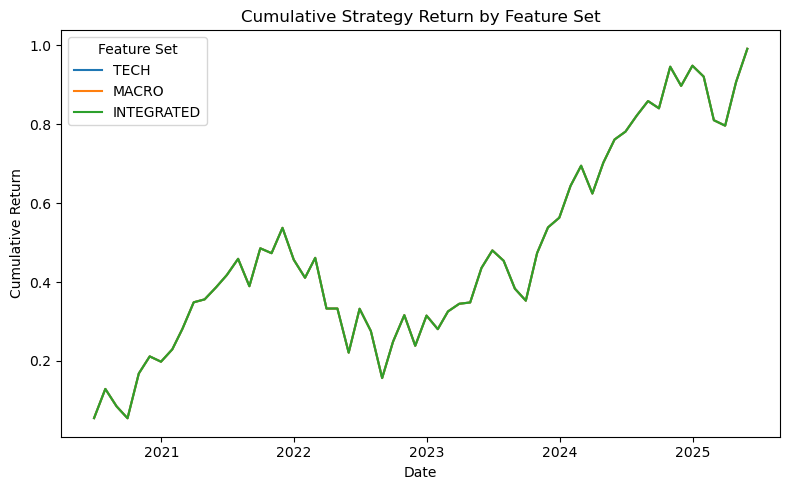

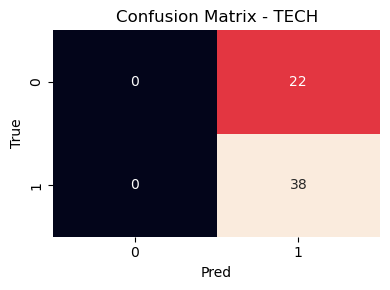

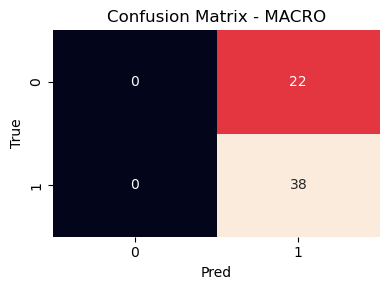

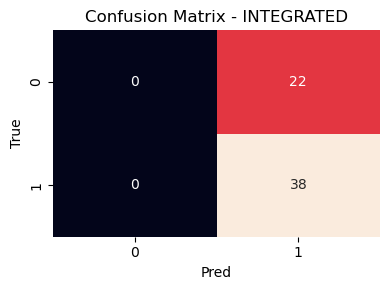

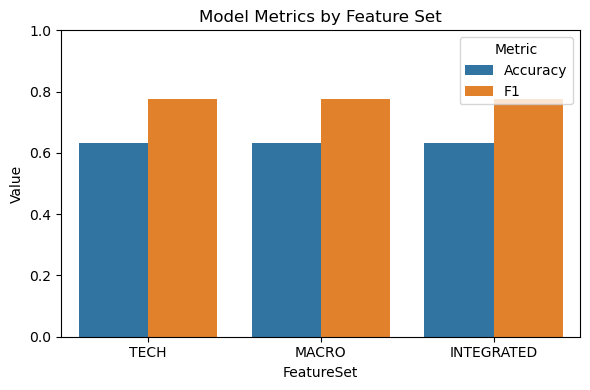

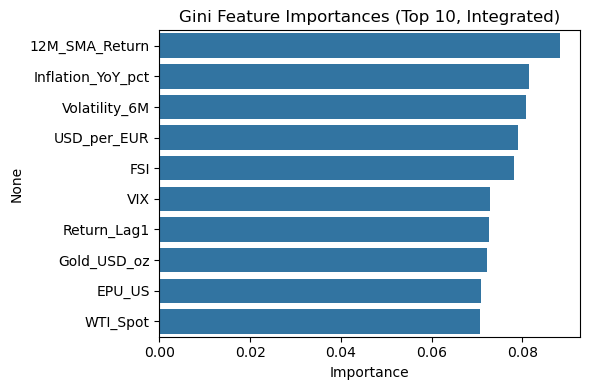

In [9]:
# Step7 Plots
# Cumulative return: assume strategy returns = actual return when predicted "Up"
plt.figure(figsize=(8,5))
for fs_name, df_fore in walkforecasts.items():
    ret = df_fore["y_ret"]
    pos = df_fore["y_pred"]
    strat_ret = (1 + (ret/100) * pos).cumprod() - 1
    plt.plot(strat_ret.index, strat_ret, label=fs_name)
plt.legend(title="Feature Set")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Strategy Return by Feature Set")
plt.tight_layout()
plt.show()

# Confusion matrices
for fs_name, df_fore in walkforecasts.items():
    cm = confusion_matrix(df_fore["y_true"], df_fore["y_pred"])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix - {fs_name}")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.tight_layout()
    plt.show()

# Metric bars (Accuracy and F1) by feature set
metrics_df = pd.DataFrame([
    {
        "FeatureSet": fs,
        "Accuracy": pd.read_json(METRICS_DIR / f"rf_clf_{fs}.json", typ='series')["Accuracy"],
        "F1": pd.read_json(METRICS_DIR / f"rf_clf_{fs}.json", typ='series')["F1"]
    }
    for fs in ["TECH", "MACRO", "INTEGRATED"]
])

metrics_df_melt = metrics_df.melt(id_vars="FeatureSet", value_vars=["Accuracy", "F1"], var_name="Metric", value_name="Value")
plt.figure(figsize=(6,4))
sns.barplot(data=metrics_df_melt, x="FeatureSet", y="Value", hue="Metric")
plt.title("Model Metrics by Feature Set")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# Feature importances (Top features from integrated set for illustration)
imp_df = pd.Series(best_models["INTEGRATED"].feature_importances_, index=X_integrated.columns)
imp_df = imp_df.sort_values(ascending=False).head(10)
plt.figure(figsize=(6,4))
sns.barplot(x=imp_df.values, y=imp_df.index)
plt.title("Gini Feature Importances (Top 10, Integrated)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [10]:
# Step8 Persistenz
for fs_name, model in best_models.items():
    joblib.dump(model, MODELS_DIR / f"rf_clf_{fs_name}.pkl")
    walkforecasts[fs_name].to_csv(FORECASTS_DIR / f"rf_clf_{fs_name}.csv", index=True)
    logger.info(f"Saved model and forecasts for {fs_name}")


INFO | Saved model and forecasts for TECH
INFO | Saved model and forecasts for MACRO
INFO | Saved model and forecasts for INTEGRATED


INFO | Saved summary metrics CSV: C:\Users\gamer\Desktop\AktienPrognose\artifacts\rf_clf_summary_metrics.csv
INFO | Saved summary metrics PNG


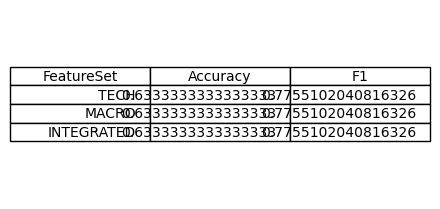

In [11]:
# Step9 Übersicht 22
# Summary table RF metrics by feature set
summary = []
for fs_name in ["TECH", "MACRO", "INTEGRATED"]:
    metrics = json.loads((METRICS_DIR / f"rf_clf_{fs_name}.json").read_text())
    summary.append({"FeatureSet": fs_name, **metrics})

df_summary = pd.DataFrame(summary)
summary_csv = ARTIFACTS / "rf_clf_summary_metrics.csv"
df_summary.to_csv(summary_csv, index=False)
logger.info(f"Saved summary metrics CSV: {summary_csv}")

# Save table as PNG
fig, ax = plt.subplots(figsize=(4.5, len(df_summary)*0.4+1))
ax.axis("off")
table = ax.table(cellText=df_summary.values, colLabels=df_summary.columns, loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.tight_layout()
plt.savefig(ARTIFACTS / "rf_clf_summary_metrics.png")
logger.info("Saved summary metrics PNG")
